Data Overview:
   CustomerID  Age  Gender  Tenure  MonthlyCharges        Contract  \
0           1   56  Female      68          147.58        Two year   
1           2   69    Male      32           22.54  Month-to-month   
2           3   46  Female      10           52.47        One year   
3           4   32    Male      22          109.67  Month-to-month   
4           5   60  Female      54          130.98  Month-to-month   

      PaymentMethod  TotalCharges Churn  
0     Bank transfer      10052.03    No  
1      Mailed check        686.78    No  
2  Electronic check        537.88    No  
3      Mailed check       2390.04   Yes  
4       Credit card       7081.28    No  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   CustomerID      100000 non-null  int64  
 1   Age             100000 non-null  int64  
 2   Ge

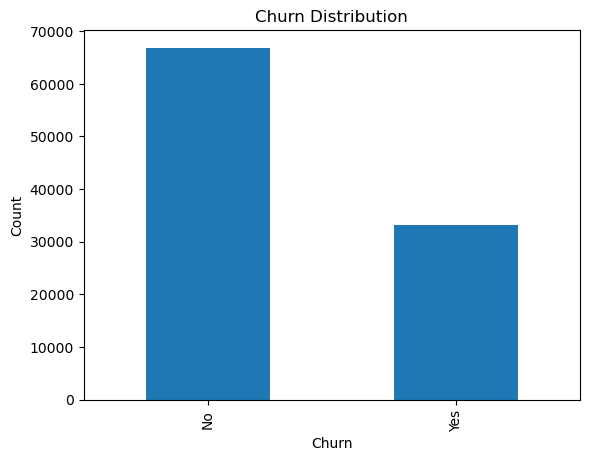

<Figure size 1000x800 with 0 Axes>

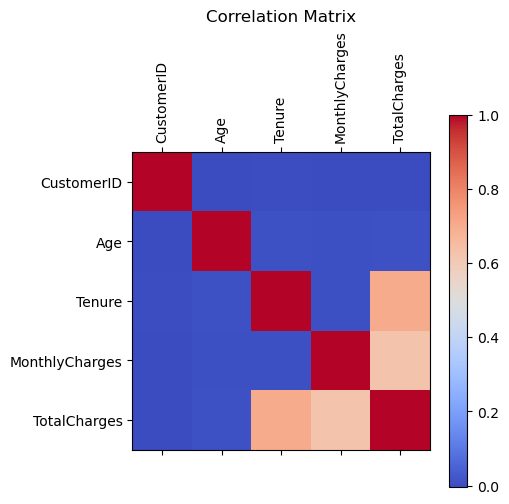

Epoch [10/100], Loss: 0.6471
Epoch [20/100], Loss: 0.6166
Epoch [30/100], Loss: 0.5939
Epoch [40/100], Loss: 0.5770
Epoch [50/100], Loss: 0.5646
Epoch [60/100], Loss: 0.5555
Epoch [70/100], Loss: 0.5490
Epoch [80/100], Loss: 0.5441
Epoch [90/100], Loss: 0.5404
Epoch [100/100], Loss: 0.5375

Test Accuracy: 72.14%
Precision: 0.6609
Recall: 0.3346
F1 Score: 0.4443


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Load the data
df = pd.read_csv('Telecome.csv')

# Basic EDA
print("Data Overview:")
print(df.head())
print("\nData Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())
print("\nChurn Distribution:")
print(df['Churn'].value_counts(normalize=True) * 100)  # Percentage

# Visualize churn rate
df['Churn'].value_counts().plot(kind='bar', title='Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

# Visualize correlations (numeric features)
numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
plt.matshow(corr_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.colorbar()
plt.show()

# Preprocess for modeling
# Map Churn to binary (0/1)
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Drop irrelevant column
df = df.drop('CustomerID', axis=1)

# One-hot encode categorical columns
cat_cols = ['Gender', 'Contract', 'PaymentMethod']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Separate features and target
X = df.drop('Churn', axis=1).values.astype(np.float32)
y = df['Churn'].values.astype(np.float32)

# Manual train-test split (80/20)
np.random.seed(42)
indices = np.random.permutation(len(X))
split = int(0.8 * len(X))
train_idx, test_idx = indices[:split], indices[split:]
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Scale numerical features (manual standardization)
num_cols_indices = [0, 1, 2, 3]  # Age, Tenure, MonthlyCharges, TotalCharges (after dummies, adjust if needed)
mean = np.mean(X_train[:, num_cols_indices], axis=0)
std = np.std(X_train[:, num_cols_indices], axis=0)
X_train[:, num_cols_indices] = (X_train[:, num_cols_indices] - mean) / std
X_test[:, num_cols_indices] = (X_test[:, num_cols_indices] - mean) / std

# Convert to PyTorch tensors
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train).unsqueeze(1)  # For binary classification
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test).unsqueeze(1)

# Define a simple neural network model (logistic regression equivalent)
class ChurnModel(nn.Module):
    def __init__(self, input_size):
        super(ChurnModel, self).__init__()
        self.fc = nn.Linear(input_size, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.fc(x))

# Initialize model, loss, optimizer
input_size = X_train.shape[1]
model = ChurnModel(input_size)
criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate on test set
model.eval()
with torch.no_grad():
    pred = model(X_test)
    pred_binary = (pred > 0.5).float()
    accuracy = (pred_binary == y_test).float().mean().item()
    print(f'\nTest Accuracy: {accuracy * 100:.2f}%')

# Optional: Classification report (manual, since no sklearn)
tp = ((pred_binary == 1) & (y_test == 1)).sum().item()
fp = ((pred_binary == 1) & (y_test == 0)).sum().item()
tn = ((pred_binary == 0) & (y_test == 0)).sum().item()
fn = ((pred_binary == 0) & (y_test == 1)).sum().item()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

# 1. DATA PREPARATION
df = pd.read_csv("Telecome.csv")
df = df.drop(columns=['CustomerID'], errors='ignore')

# Standardize target
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0, 'True': 1, 'False': 0, 1: 1, 0: 0})

# Encode categorical variables
X = pd.get_dummies(df.drop(columns=['Churn']), drop_first=True)
y = df['Churn'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale data (Essential for Models 1, 2, and 3)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results = []

def log_result(name, y_true, y_pred):
    results.append({
        "Model": name,
        "Accuracy": f"{accuracy_score(y_true, y_pred):.4f}",
        "Precision": f"{precision_score(y_true, y_pred):.4f}",
        "Recall": f"{recall_score(y_true, y_pred):.4f}",
        "F1-Score": f"{f1_score(y_true, y_pred):.4f}"
    })

# --- MODEL 1: Logistic Regression ---
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_scaled, y_train)
log_result("Model-1: Logistic Regression", y_test, model_lr.predict(X_test_scaled))

# --- MODEL 2: Torch Model ---
X_train_t = torch.FloatTensor(X_train_scaled)
y_train_t = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_t = torch.FloatTensor(X_test_scaled)

class TorchChurnNet(nn.Module):
    def __init__(self, input_dim):
        super(TorchChurnNet, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x): return self.layer(x)

t_model = TorchChurnNet(X_train_scaled.shape[1])
optimizer = optim.Adam(t_model.parameters(), lr=0.01)
criterion = nn.BCELoss()

for epoch in range(100):
    optimizer.zero_grad()
    loss = criterion(t_model(X_train_t), y_train_t)
    loss.backward()
    optimizer.step()

with torch.no_grad():
    t_preds = (t_model(X_test_t) > 0.5).numpy().astype(int)
    log_result("Model-2: Torch Churn Model", y_test, t_preds)

# --- MODEL 3: MLP Model (Sklearn) ---
model_mlp = MLPClassifier(hidden_layer_sizes=( 64, 32), max_iter=500,)
model_mlp.fit(X_train_scaled, y_train)
log_result("Model-3: MLP Model", y_test, model_mlp.predict(X_test_scaled))

# --- MODEL 4: LightGBM Model ---
model_lgbm = LGBMClassifier(n_estimators=100, learning_rate=0.05, random_state=42, verbose=-1)
model_lgbm.fit(X_train_scaled, y_train)
log_result("Model-4: LightGBM Model", y_test, model_lgbm.predict(X_test_scaled))

# 2. PRINT COMPARISON TABLE
results_df = pd.DataFrame(results)
print("\n" + results_df.to_markdown(index=False))


| Model                        |   Accuracy |   Precision |   Recall |   F1-Score |
|:-----------------------------|-----------:|------------:|---------:|-----------:|
| Model-1: Logistic Regression |     0.7234 |      0.608  |   0.4658 |     0.5275 |
| Model-2: Torch Churn Model   |     0.7481 |      0.66   |   0.4952 |     0.5659 |
| Model-3: MLP Model           |     0.7596 |      0.6646 |   0.5545 |     0.6046 |
| Model-4: LightGBM Model      |     0.7624 |      0.67   |   0.5579 |     0.6088 |
